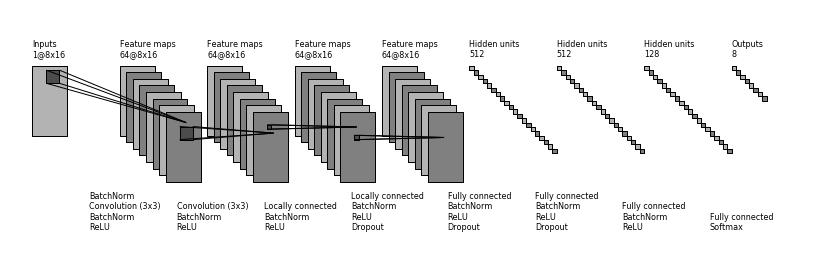

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
#plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
%matplotlib inline


NumConvMax = 8
NumFcMax = 20
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Black = 0.


def add_layer(patches, colors, size=24, num=5,
              top_left=[0, 0],
              loc_diff=[3, -3],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    h = 2 * size if size == 16 else size
    loc_start = top_left - np.array([0, h])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size, h))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_mapping(patches, colors, start_ratio, patch_size, ind_bgn,
                top_left_list, loc_diff_list, num_show_list, size_list):

    start_loc = top_left_list[ind_bgn] \
        + (num_show_list[ind_bgn] - 1) * np.array(loc_diff_list[ind_bgn]) \
        + np.array([start_ratio[0] * size_list[ind_bgn],
                    -start_ratio[1] * size_list[ind_bgn]])

    end_loc = top_left_list[ind_bgn + 1] \
        + (num_show_list[ind_bgn + 1] - 1) \
        * np.array(loc_diff_list[ind_bgn + 1]) \
        + np.array([(start_ratio[0] + .5 * patch_size / size_list[ind_bgn]) *
                    size_list[ind_bgn + 1],
                    -(start_ratio[1] - .5 * patch_size / size_list[ind_bgn]) *
                    size_list[ind_bgn + 1]])

    patches.append(Rectangle(start_loc, patch_size, patch_size))
    colors.append(Dark)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Black)
    patches.append(Line2D([start_loc[0] + patch_size, end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Black)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1] + patch_size, end_loc[1]]))
    colors.append(Black)
    patches.append(Line2D([start_loc[0] + patch_size, end_loc[0]],
                          [start_loc[1] + patch_size, end_loc[1]]))
    colors.append(Black)


def label(xy, text, xy_off=[0, 4]):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text,
             family='sans-serif', size=8)


fc_unit_size = 2
layer_width = 40

patches = []
colors = []

fig, ax = plt.subplots()


############################
# conv layers
size_list = [16, 16, 16, 16, 16]
num_list = [1, 64, 64, 64, 64]
x_diff_list = [0, layer_width, layer_width, layer_width, layer_width]
text_list = ['Inputs'] + ['Feature maps'] * (len(size_list) - 1)
loc_diff_list = [[3, -3]] * len(size_list)

num_show_list = map(min, num_list, [NumConvMax] * len(num_list))
top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]

for ind in range(len(size_list)):
    add_layer(patches, colors, size=size_list[ind],
              num=num_show_list[ind],
              top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
    label(top_left_list[ind], text_list[ind] + '\n{}@{}x{}'.format(
        num_list[ind], size_list[ind] // 2, size_list[ind]))


############################
# in between layers
start_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
patch_size_list = [3, 3, 1, 1]
ind_bgn_list = range(len(patch_size_list))
text_list = ['BatchNorm\nConvolution (3x3)\nBatchNorm\nReLU',
             'Convolution (3x3)\nBatchNorm\nReLU',
             'Locally connected\nBatchNorm\nReLU',
             'Locally connected\nBatchNorm\nReLU\nDropout']

for ind in range(len(patch_size_list)):
    add_mapping(patches, colors, start_ratio_list[ind],
                2 * patch_size_list[ind], ind,
                top_left_list, loc_diff_list, num_show_list, size_list)
    label(top_left_list[ind], text_list[ind], xy_off=[26, -75])


############################
# fully connected layers
size_list = [fc_unit_size, fc_unit_size, fc_unit_size, fc_unit_size]
num_list = [512, 512, 128, 8]
num_show_list = map(min, num_list, [NumFcMax] * len(num_list))
x_diff_list = [sum(x_diff_list) + layer_width, layer_width, layer_width, layer_width]
top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]
loc_diff_list = [[fc_unit_size, -fc_unit_size]] * len(top_left_list)
text_list = ['Hidden units'] * (len(size_list) - 1) + ['Outputs']

for ind in range(len(size_list)):
    add_layer(patches, colors, size=size_list[ind], num=num_show_list[ind],
              top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
    label(top_left_list[ind], text_list[ind] + '\n{}'.format(
        num_list[ind]))

text_list = (
    ['Fully connected\nBatchNorm\nReLU\nDropout'] * 2 + 
    ['Fully connected\nBatchNorm\nReLU', 'Fully connected\nSoftmax']
)

for ind in range(len(size_list)):
    label(top_left_list[ind], text_list[ind], xy_off=[-10, -75])

############################
colors += [0, 1]
collection = PatchCollection(patches, cmap=plt.cm.gray)
collection.set_array(np.array(colors))
ax.add_collection(collection)
plt.tight_layout()
plt.axis('equal')
plt.axis('off')
fig.set_size_inches(12, 4)

def savefig(prefix):
    for ext in ['.jpg', '.eps', '.pdf']:
        plt.savefig(prefix + ext, dpi=300, bbox_inches='tight', pad_inches=0.1)
        
        
savefig('../.cache/figures/chi-convnet')

#fig_dir = './'
#fig_ext = '.png'
#fig.savefig(os.path.join(fig_dir, 'convnet_fig' + fig_ext),
#            bbox_inches='tight', pad_inches=0)